<img src="./data/logo.png" width="400" height="400">

# 웹/앱 접속 시간에 따른 지출 현황 분석 및 매출 개선 전략 수립
---
- 분석 목표 : 서비스 내 고객 별 접속 현황과 연간 지출액을 살펴보고, 매출을 높이기 위한 전략을 수립한다.
- 데이터 출처 : [Ecommerce Customers | Kaggle](https://www.kaggle.com/srolka/ecommerce-customers)


## 1. 가설 설정
---
각 컬럼 정보를 확인하고, 분석 목표에 도달하기 위한 가설을 설정한다.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
customer_r = pd.read_csv('./data/customers.csv').iloc[:,3:]
customer_r

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,34.497268,12.655651,39.577668,4.082621,587.951054
1,31.926272,11.109461,37.268959,2.664034,392.204933
2,33.000915,11.330278,37.110597,4.104543,487.547505
3,34.305557,13.717514,36.721283,3.120179,581.852344
4,33.330673,12.795189,37.536653,4.446308,599.406092
...,...,...,...,...,...
495,33.237660,13.566160,36.417985,3.746573,573.847438
496,34.702529,11.695736,37.190268,3.576526,529.049004
497,32.646777,11.499409,38.332576,4.958264,551.620145
498,33.322501,12.391423,36.840086,2.336485,456.469510


각 컬럼은 아래 정보를 담고 있다.<br>
1. Avg.Session Length : 평균 세션 지속 시간
2. Time on App : App 접속 시간
3. Time on Website : Website 접속 시간
4. Length of Membership : 가입 기간
5. Yearly Amount Spent : 연간 지출액


In [104]:
# 결측치 및 데이터 타입 확인
customer_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Avg. Session Length   500 non-null    float64
 1   Time on App           500 non-null    float64
 2   Time on Website       500 non-null    float64
 3   Length of Membership  500 non-null    float64
 4   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5)
memory usage: 19.7 KB


In [50]:
# 데이터 분포 통계 확인
customer_r.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


각 컬럼의 단위는(분,시간,일,월)는 정확히 알 수 없고, 값이 크고 작다에 대한 인지만 가능한 상황이다. 따라서 이번 분석에는 임의로 주어진 데이터의 단위를 납득 가능한 수준에서 부여하고자 한다.

1. Avg.Session Length (분)
2. Time on App (분)
3. Time on Website (분)
4. Length of Membership (월)
5. Yearly Amount Spent (천 원)

먼저, 세션 길이는 평균 33분으로 `Time on App`, `Time on Website`와 데이터 범위가 매우 유사하다.<br>
두 개의 `Time on ~ ` 컬럼을 빈도(접속 횟수)로 이해하기에는 각 row가 연간 집계 데이터임을 감안할 때 적절하지 않다. 따라서 앞 3개 컬럼은 모두 단위를 '분'으로 통합하겠다. 정보 손실을 피하기 위해 소수점 이하는 제거하지 않고 '초' 이하 단위로 본다.<br>

다음으로 `Length of Membership`의 경우 모든 데이터가 0~12 사이에 분포한다. <br>
'월' 단위로 고려하고, 정보 손실을 피하기 위해 소수점 이하는 제거하지 않고 '일' 이하(일,시간,분..) 단위로 본다.

마지막으로 분석 대상을 대형 플랫폼 기업이 아닌 국내 소규모 커머스로 가정하기 위해 `Yearly Amount Spent`는 '천 원' 단위로 약속하고 마찬가지로 정보 손실을 피하기 위해 소수점 이하는 제거하지 않는다.



In [105]:
# 전처리 전 원본 데이터 복사
customer = customer_r.copy()

# 에러를 줄이기 위해 컬럼명 변경
customer.columns = ['session','app','web','membership','spent']


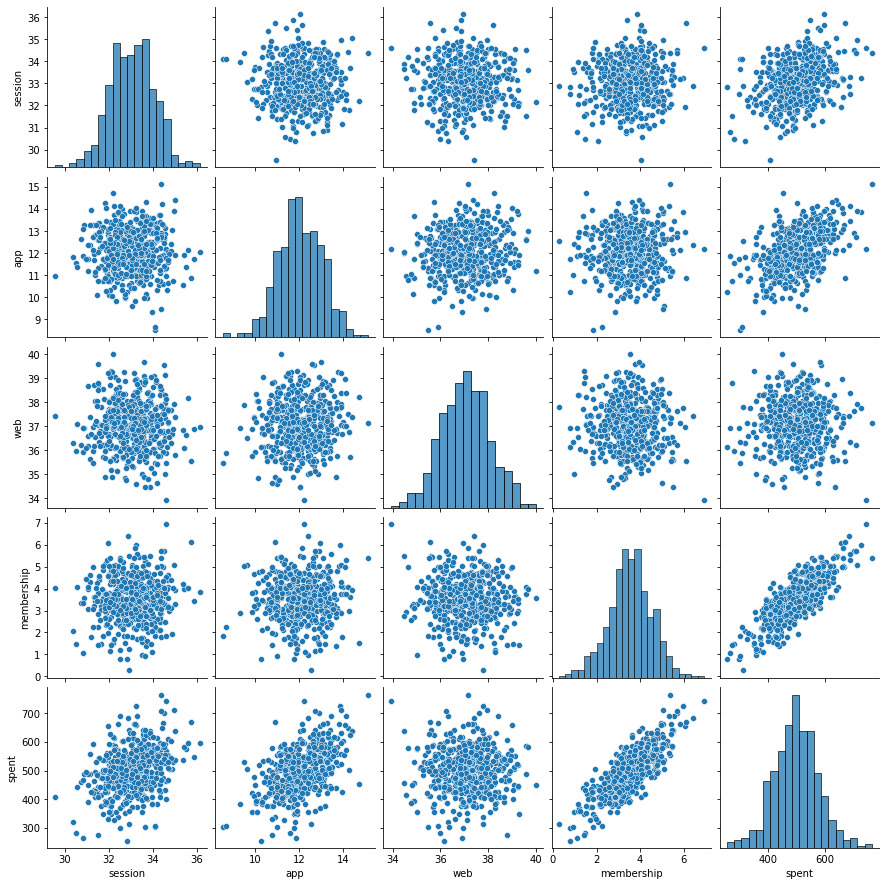

In [106]:
# 데이터 분포 시각화
sns.pairplot(customer);

결측치는 없고, 모두 숫자형(float64)으로 잘 저장되어 있다.

또한, 모든 컬럼은 정규분포 형태를 띄며 연간 지출액(Yearly Amount Spent)을 제외한 4개의 독립변수는 서로 상관성이 없는 것으로 보인다. 정규성 및 독립변수간 다중공선성 확인 후 결과에 따라 예측 분석을 추가한다.

멤버십 유지(구독) 기간은 연간 지출액과 가장 관련이 깊으나 이는 재구매에 따른 구독 연장으로도 볼 수 있기 때문에 단독 지표로는 전략 수립에 도움이 되지 않는다. <br>


따라서 구독 기간에 따른 웹, 앱 접속 시간 별 연간 지출액을 확인하여 차별화 전략을 수립한다.

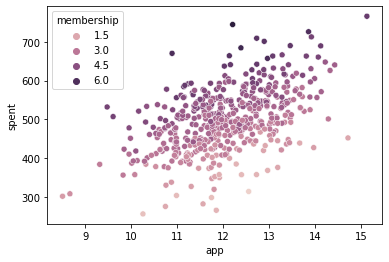

In [109]:
sns.scatterplot(data=customer, x='app',y='spent',hue='membership');

In [123]:
customer.loc[customer['membership']<3.5,'app'].count()

241

In [125]:
mem_median = customer['membership'].median()
print('멤버십 유지기간 상위 50% 고객의 ' customer.loc[customer['membership']>mem_median,'app'].count()

250

In [130]:
app_freq = customer['app']/(customer['app'] + customer['web'])
app_freq

0      0.242291
1      0.229637
2      0.233899
3      0.271964
4      0.254217
         ...   
495    0.271409
496    0.239245
497    0.230764
498    0.251697
499    0.257706
Length: 500, dtype: float64

In [132]:
customer['app_freq'] = app_freq

<AxesSubplot:xlabel='app_freq', ylabel='spent'>

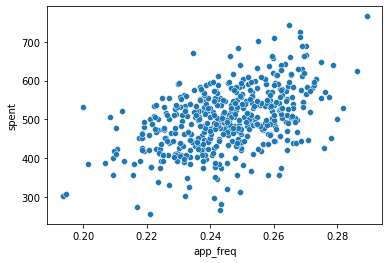

In [135]:
sns.scatterplot(data=customer, x='app_freq', y='spent')

웹보다 앱을 사용하는 비중이 높을 수록 연간 지출액은 상승한다.

<AxesSubplot:xlabel='app', ylabel='spent'>

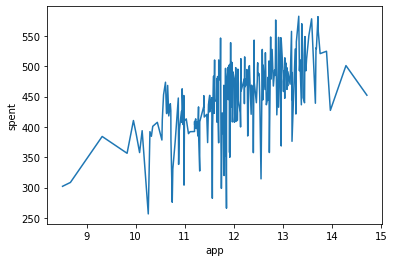

In [128]:
sns.lineplot(data=customer.loc[customer['membership']<3.5], x='app', y='spent')

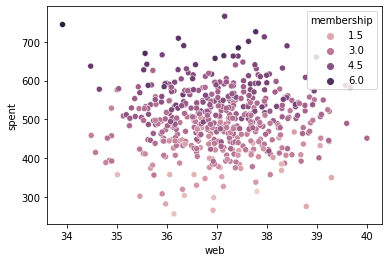

In [116]:
sns.scatterplot(data=customer, x='web',y='spent',hue='membership');

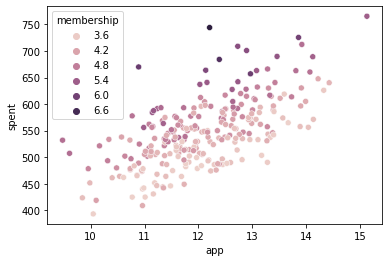

In [138]:
sns.scatterplot(data=customer.loc[customer['membership']>3.5], x='app',y='spent',hue='membership');

[3월까지 쇼핑 앱 사용자수 '3500만'- 70%가 앱으로 쇼핑, 정보통신신문](https://www.koit.co.kr/news/articleView.html?idxno=82667)

0. 현재 모든 고객이 앱을 설치한 상황이다.(로그찍힘)
1. 그러나 앱보다 웹의 사용 시간이 길다.
2. 앱, 웹 모두 보유한 서비스가 점점 앱 커머스 시장이 커지고 있는 상황에서도 웹 사용 빈도가 높다는 것은 앱서비스 개선이 필요한 상황을 ?
1. 이 서비스에서도 볼 수 있듯이 앱은 웹보다 사용빈도가 적지만 지출액과의 선형관계가 더 뚜렷하다.
2. 따라서 앱은 접속 시간이 늘어나면 지출액도 늘어나는 양상이 있다.
3. 하지만 앱은 진입장벽으로 

In [107]:
본 분석에서 검증해나갈 가설은 아래와 같다.(H1 = 연구가설)<br>
1. H1 : 웹보다 앱 접속 시간이 연간 지출액과 관련성이 더 크다.
2. H2 : 

SyntaxError: invalid syntax (<ipython-input-107-b718b58d80b3>, line 1)